# Tranfer Leaning with Tensorflow Part 3: Scaling up 

We already see the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10 of the training (leveragin the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf.

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
!nvidia-smi

Sun Feb 19 03:24:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing helper fuctions

In [2]:
# Get helper_functions.py script from my GitHub
!wget https://raw.githubusercontent.com/Charliecr94/Tensor_flow_projects/main/Extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

--2023-02-19 03:24:59--  https://raw.githubusercontent.com/Charliecr94/Tensor_flow_projects/main/Extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10234 (10.0K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]   9.99K  --.-KB/s    in 0s      

2023-02-19 03:24:59 (87.6 MB/s) - ‘helper_functions.py.2’ saved [10234/10234]



# 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original Food101 dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.



## Downloading and preprocessing the data



In [3]:
# Get 10% of the data of the 101 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 
unzip_data("101_food_classes_10_percent.zip")

--2023-02-19 03:25:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 142.250.103.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

101_food_classes_10 100%[===================>]   1.51G   159MB/s    in 11s     

2023-02-19 03:25:18 (147 MB/s) - ‘101_food_classes_10_percent.zip.2’ saved [1625420029/1625420029]



In [40]:
# How many classes are there?
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/deviled_eggs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/waffles'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/crab_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macarons'.
There are 0 directories and 250 images in '101_food_classes

In [5]:
# Setup data inputs.
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent= tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size= IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

  * Create a ModelCheckpoint Callback.
  * Create a data augmentation layer to build data augmentation right into the model.
  * Build a Functional EfficienteNetB0 backboned-model.
  * Compile our model.
  * Feature extract for 5 full passes.

In [6]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor= 'val_accuracy',
                                                         save_best_only= True)

In [7]:
# Create  data augmentation layer.
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
],name ="data_augmentation")

In [8]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation= "softmax", name="output_layer")(x)


model = tf.keras.Model(inputs, outputs)


In [9]:
# Compile 
model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data= test_data,
                                           validation_steps= int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5


237/237 [==============================] - 163s 628ms/step - loss: 3.3854 - accuracy: 0.2722 - val_loss: 2.6154 - val_accuracy: 0.4081
Epoch 2/5
237/237 [==============================] - 106s 439ms/step - loss: 2.2049 - accuracy: 0.5013 - val_loss: 2.1351 - val_accuracy: 0.4958
Epoch 3/5
237/237 [==============================] - 95s 401ms/step - loss: 1.8312 - accuracy: 0.5641 - val_loss: 1.9801 - val_accuracy: 0.5026
Epoch 4/5
237/237 [==============================] - 92s 387ms/step - loss: 1.6182 - accuracy: 0.6046 - val_loss: 1.8601 - val_accuracy: 0.5273
Epoch 5/5
237/237 [==============================] - 91s 384ms/step - loss: 1.4461 - accuracy: 0.6469 - val_loss: 1.8289 - val_accuracy: 0.5257


In [10]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 65s 82ms/step - loss: 1.5863 - accuracy: 0.5838


[1.5863438844680786, 0.5837623476982117]

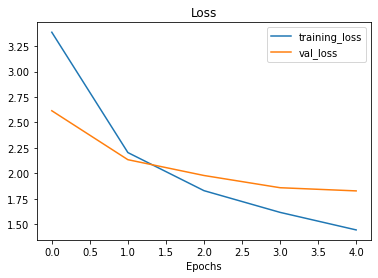

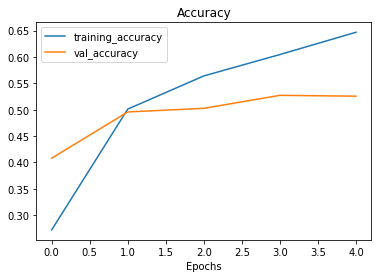

In [11]:
plot_loss_curves(history_all_classes_10_percent)

Seems that our model achieve good results, but the training accuracy and val_accuracy are pretty distant soo maybe our model are **'overfitting'**.

Soo let's try to unfreze some of the base layers in the base model.

## Fine-tuning it

In [12]:
# Unfreeze all of the layers in the base model
base_model.trainable= True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [13]:
# Recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [14]:
# What layers in the model are trainable?
for layer in  model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [15]:
# Fine-tune_epochs
fine_tune_epochs = 10

# Fine-tune for 5 more epochs
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                      epochs= fine_tune_epochs,
                                                      validation_data= test_data,
                                                      validation_steps=int(0.15*len(test_data)),
                                                      initial_epoch= history_all_classes_10_percent.epoch[-1])

Epoch 5/10


237/237 [==============================] - 95s 354ms/step - loss: 1.2240 - accuracy: 0.6799 - val_loss: 1.7680 - val_accuracy: 0.5365
Epoch 6/10
237/237 [==============================] - 91s 381ms/step - loss: 1.1074 - accuracy: 0.7039 - val_loss: 1.7715 - val_accuracy: 0.5410
Epoch 7/10
237/237 [==============================] - 78s 328ms/step - loss: 1.0090 - accuracy: 0.7340 - val_loss: 1.7321 - val_accuracy: 0.5469
Epoch 8/10
237/237 [==============================] - 81s 339ms/step - loss: 0.9640 - accuracy: 0.7420 - val_loss: 1.7509 - val_accuracy: 0.5450
Epoch 9/10
237/237 [==============================] - 79s 333ms/step - loss: 0.8841 - accuracy: 0.7638 - val_loss: 1.8040 - val_accuracy: 0.5371
Epoch 10/10
237/237 [==============================] - 77s 324ms/step - loss: 0.8344 - accuracy: 0.7748 - val_loss: 1.7691 - val_accuracy: 0.5434


In [16]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results 

790/790 [==============================] - 64s 81ms/step - loss: 1.4911 - accuracy: 0.6045


[1.4910563230514526, 0.6044752597808838]

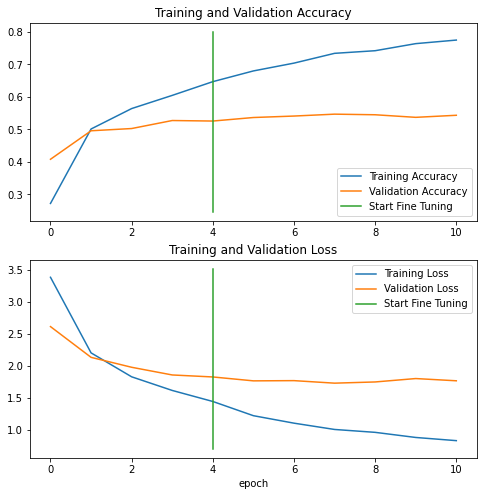

In [17]:
# Compare the histories of feature extration model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                new_history=history_all_classes_10_percent_fine_tune,
                initial_epochs=5)

It seems that afeter fine-tuning, our model reach to improved significantly but validation are still the same.
Thats beacause our pre-trained model, EfficientNetB0 was training in similar data on ImgaNet, which contains many real life pictures of food just like our food dataset.


## Saving and loading our model

To prevent having to retrain our model from scratch, let's save it to file using the `save()` method.



In [ ]:
# Save our fine-tuning model
model.save("drive/MyDrive/Colab Notebooks/TensorFlow/101_food_class_10_percent_saved_big_dog_model")

# Making predictions with our trained model

To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

In [19]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 66s 81ms/step


We just passed all of the test images to our model and asked it to make a prediction on what food it thinks is in eachs.

In [20]:
# How many predictions are there?
len(preds_probs)

25250

In [21]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

This is a **predictions probability tensor**.

Let's see what the firts 10 look like.

In [22]:
# How do they look?
preds_probs[:10]

array([[2.3851541e-01, 2.6394703e-04, 1.3432977e-01, ..., 1.0182645e-05,
        9.2468392e-03, 1.8277377e-02],
       [9.4553596e-01, 9.1628038e-09, 9.9334144e-04, ..., 3.2948861e-03,
        3.3734477e-07, 8.1023536e-06],
       [4.1322491e-01, 8.5167373e-03, 5.2297036e-03, ..., 2.8271074e-04,
        8.0708723e-04, 4.5259614e-03],
       ...,
       [2.4995615e-01, 8.6312357e-06, 2.4665843e-03, ..., 4.7229514e-02,
        8.4529718e-04, 1.7880944e-04],
       [1.6611581e-01, 8.9268456e-04, 1.7580795e-01, ..., 2.3472084e-04,
        1.0892961e-03, 2.4324533e-04],
       [5.9216285e-01, 3.3762495e-07, 1.7190144e-03, ..., 3.3060869e-03,
        1.4342693e-06, 9.6185278e-04]], dtype=float32)

We can find the index of the maximum value in each prediction probability tensor using the argmax() method.

In [23]:
# Get the class predictions of eachs label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29,  0,  9,  0])

In [24]:
# unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)
     

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Nice! Since `test_data` isn't shuffled, the `y_labels` array comes back in the same order as the `pred_classes` array.

The final check is to see how many labels we've got.

In [25]:
# How many labels are there
len(y_labels)

25250

# Evaluating our model's predictions

In [26]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

sklearn_accuracy

0.6044752475247525

In [27]:
# Get the class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

### Making a Confusion Matrix for 101 classes

In [28]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

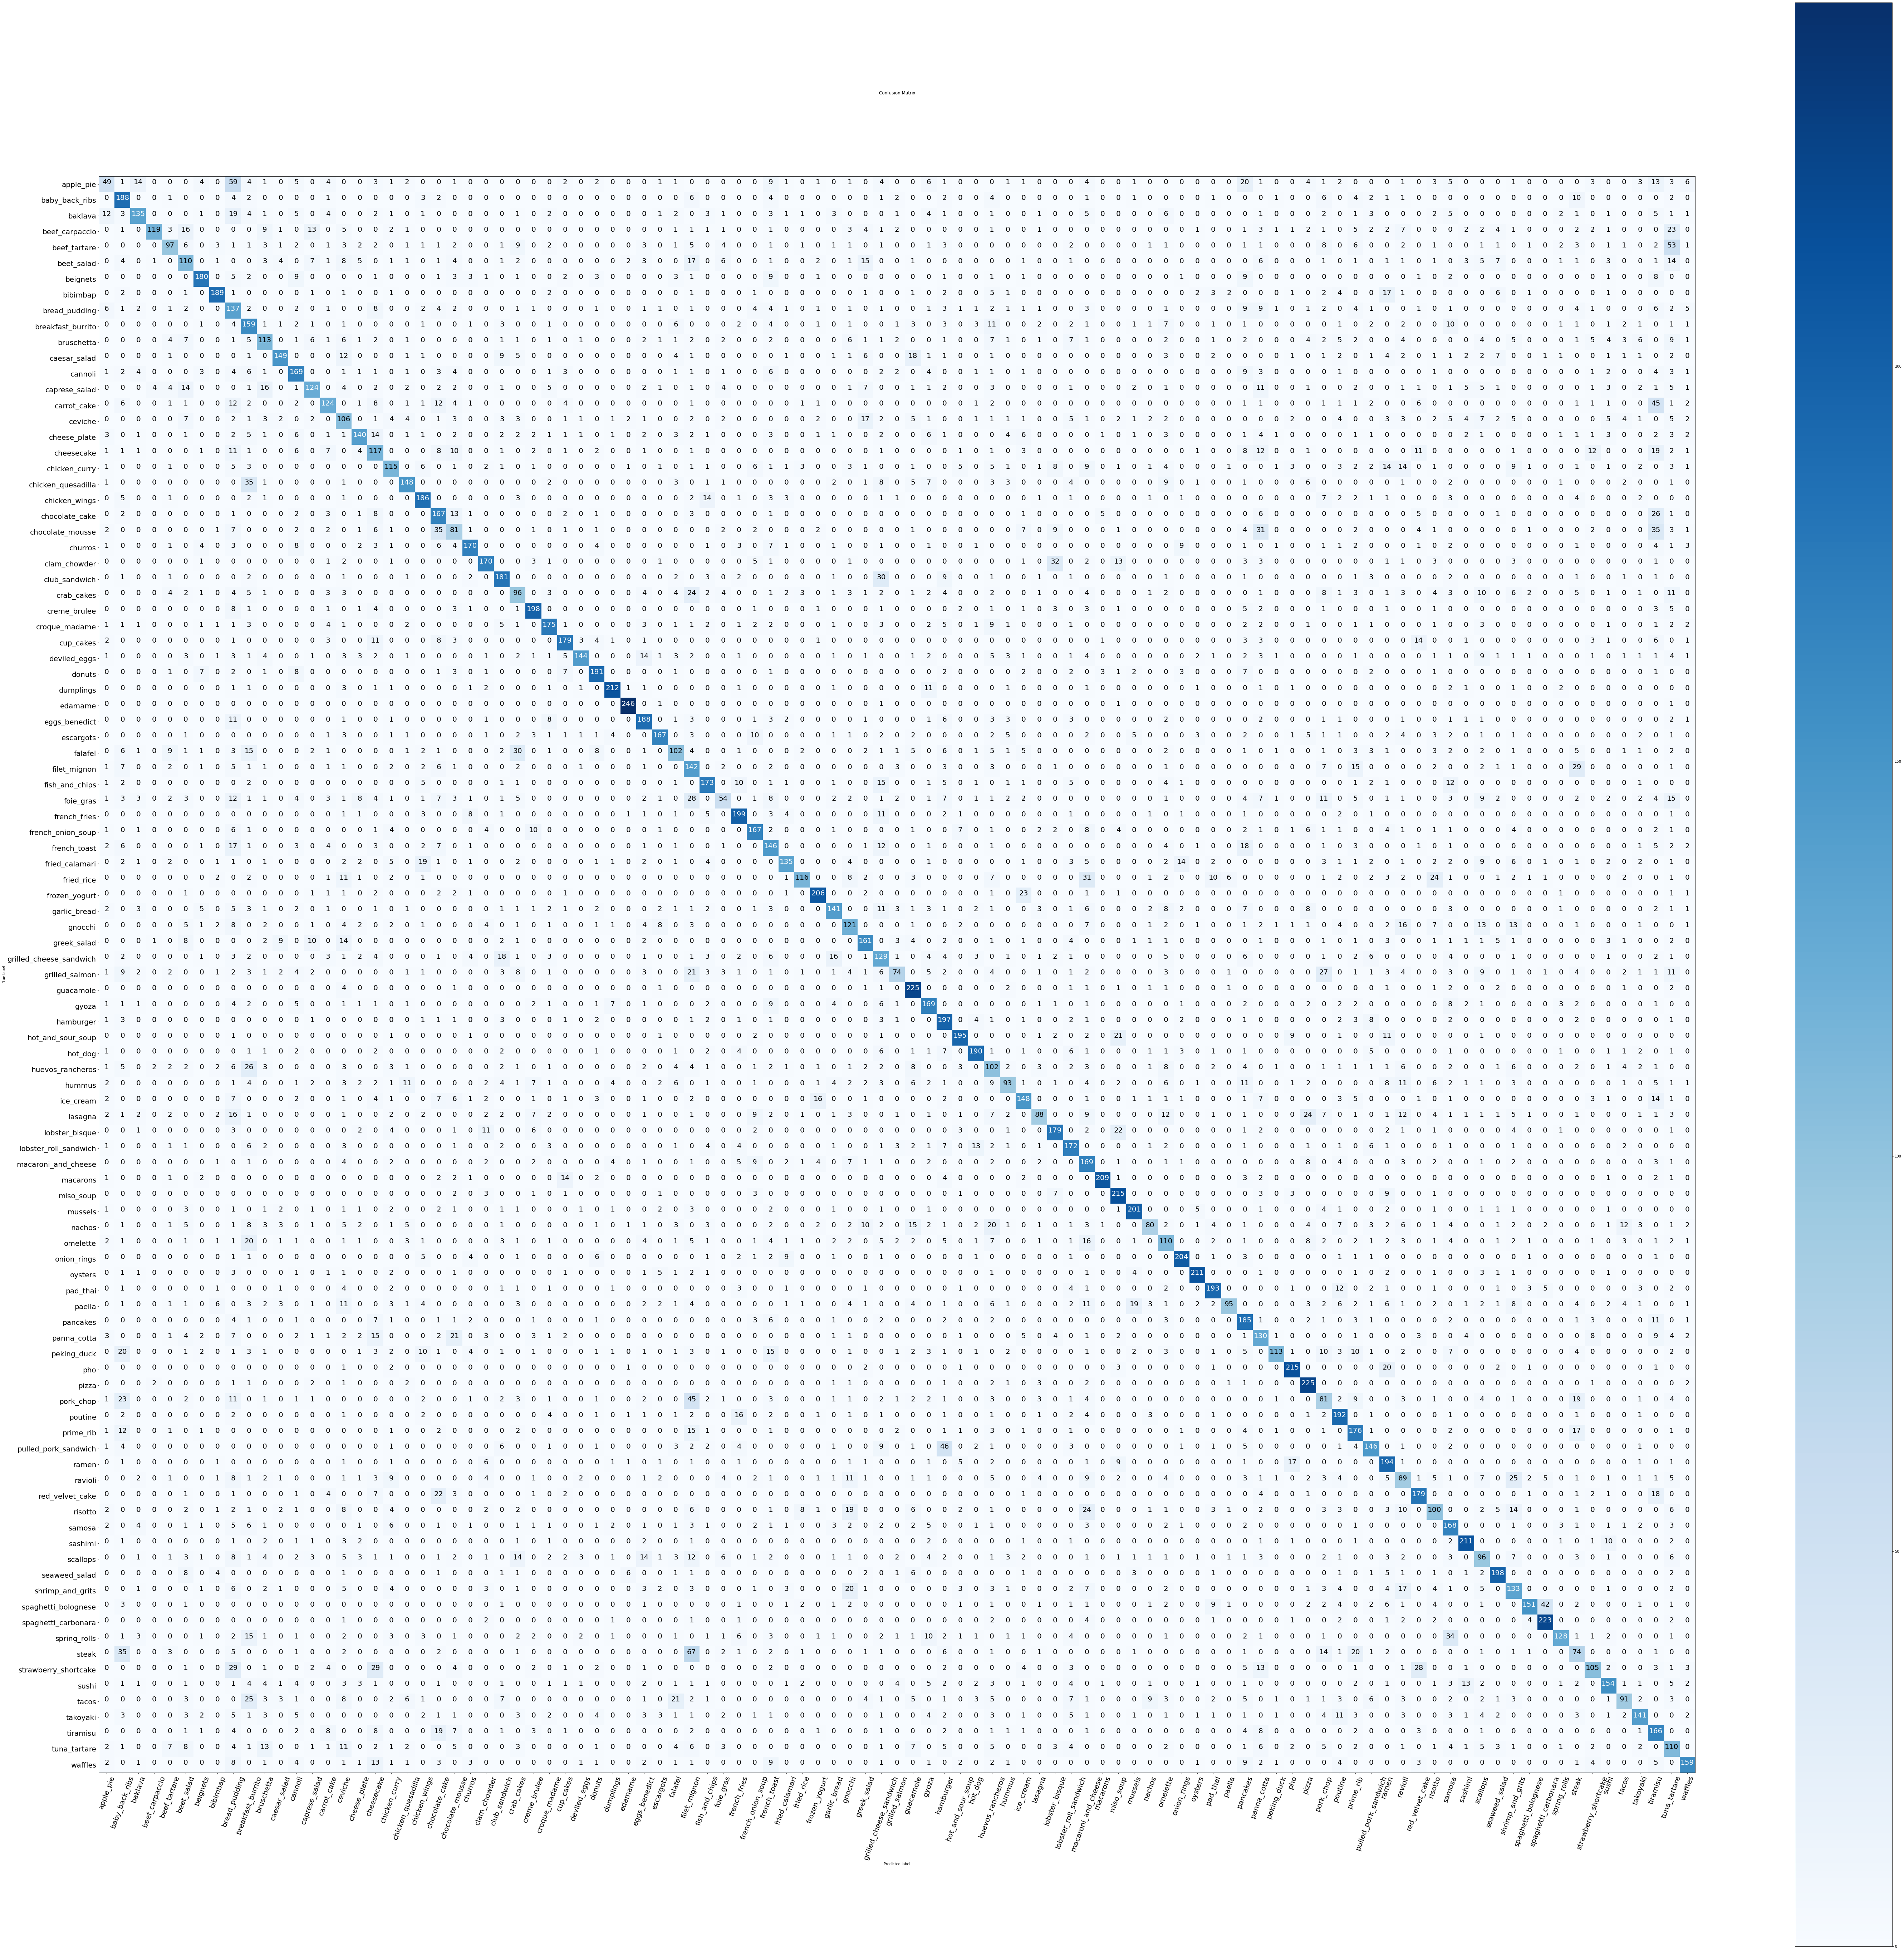

In [29]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes.
make_confusion_matrix(y_true = y_labels,
                      y_pred= pred_classes,
                      classes= class_names,
                      figsize=(100,100),
                      text_size=20,
                      norm=False,
                      savefig= True)

It looks like the model gets most confused on classes which look visualually similar, such as predicting **filet_mignon** for instances of **pork_chop** and **chocolate_cake** for instances of **tiramisu**.

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's **classification_report()** function.

In [32]:
# Get a dictionary of the classification report
from sklearn.metrics import classification_report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

# Getting the F1-scores in a another emply dictionary.
class_f1_scores = {}

# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    # Append class names and fi-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.2655826558265582,
 'baby_back_ribs': 0.5996810207336524,
 'baklava': 0.6178489702517163,
 'beef_carpaccio': 0.6279683377308708,
 'beef_tartare': 0.47317073170731705,
 'beet_salad': 0.44715447154471544,
 'beignets': 0.7531380753138075,
 'bibimbap': 0.8008474576271186,
 'bread_pudding': 0.350832266325224,
 'breakfast_burrito': 0.47963800904977383,
 'bruschetta': 0.48085106382978726,
 'caesar_salad': 0.6819221967963386,
 'cannoli': 0.6353383458646618,
 'caprese_salad': 0.5662100456621004,
 'carrot_cake': 0.5548098434004474,
 'ceviche': 0.38336347197106696,
 'cheese_plate': 0.6208425720620844,
 'cheesecake': 0.4186046511627907,
 'chicken_curry': 0.5000000000000001,
 'chicken_quesadilla': 0.6505494505494506,
 'chicken_wings': 0.7112810707456979,
 'chocolate_cake': 0.5604026845637584,
 'chocolate_mousse': 0.35064935064935066,
 'churros': 0.7311827956989247,
 'clam_chowder': 0.7083333333333334,
 'club_sandwich': 0.6843100189035917,
 'crab_cakes': 0.4042105263157895,
 'creme_br

In [35]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores


,class_name,f1-score
33,edamame,0.959064
63,macarons,0.887473
69,oysters,0.866530
32,dumplings,0.856566
91,spaghetti_carbonara,0.839925
...,...,...
99,tuna_tartare,0.348101
77,pork_chop,0.324649
93,steak,0.313559
39,foie_gras,0.301676


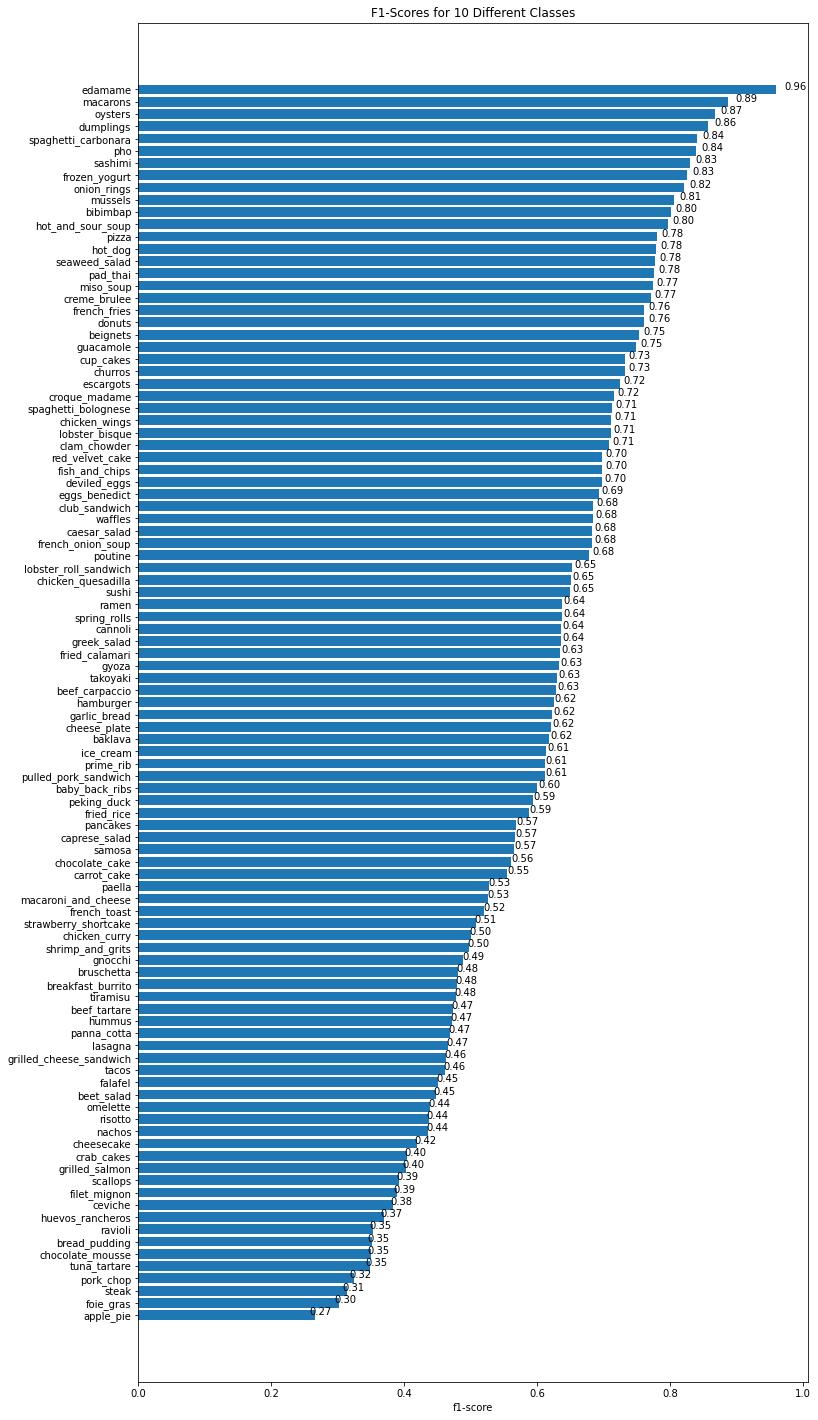

In [36]:
# Let's visualize this DataFrame

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

It seems like our model performs fairly poorly on classes like apple_pie and ravioli while for classes like edamame and pho the performance is quite outstanding.

Findings like these give us clues into where we could go next with our experiments. Perhaps we may have to collect more data on poor performing classes or perhaps the worst performing classes are just hard to make predictions on.

## Visualizing predictions on test images

In [38]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

Image loading and preprocessing function ready.

Now let's write some code to:

Load a few random images from the test dataset.
Make predictions on them.
Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

In [41]:

# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

NotFoundError: ignored

<Figure size 1224x720 with 0 Axes>